Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.3.0


# LeNet-5 QuickDraw Classifier

This notebook implements the classic LeNet-5 convolutional network [1] and applies it to MNIST digit classification. The basic architecture is shown in the figure below:

![](../images/lenet/lenet-5_1.jpg)



LeNet-5 is commonly regarded as the pioneer of convolutional neural networks, consisting of a very simple architecture (by modern standards). In total, LeNet-5 consists of only 7 layers. 3 out of these 7 layers are convolutional layers (C1, C3, C5), which are connected by two average pooling layers (S2 & S4). The penultimate layer is a fully connexted layer (F6), which is followed by the final output layer. The additional details are summarized below:

- All convolutional layers use 5x5 kernels with stride 1.
- The two average pooling (subsampling) layers are 2x2 pixels wide with stride 1.
- Throughrout the network, tanh sigmoid activation functions are used. (**In this notebook, we replace these with ReLU activations**)
- The output layer uses 10 custom Euclidean Radial Basis Function neurons for the output layer. (**In this notebook, we replace these with softmax activations**)
- The input size is 32x32; here, we rescale the MNIST images from 28x28 to 32x32 to match this input dimension. Alternatively, we would have to change the 
achieve error rate below 1% on the MNIST data set, which was very close to the state of the art at the time (produced by a boosted ensemble of three LeNet-4 networks).


### References

- [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998.

## Imports

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:3"
GRAYSCALE = True

## Dataset

This notebook is based on Google's Quickdraw dataset (https://quickdraw.withgoogle.com). In particular we will be working with an arbitrary subset of 10 categories in png format:

    label_dict = {
             "lollipop": 0,
             "binoculars": 1,
             "mouse": 2,
             "basket": 3,
             "penguin": 4,
             "washing machine": 5,
             "canoe": 6,
             "eyeglasses": 7,
             "beach": 8,
             "screwdriver": 9,
    }
    
(The class labels 0-9 can be ignored in this notebook). 

For more details on obtaining and preparing the dataset, please see the

- [custom-data-loader-quickdraw.ipynb](custom-data-loader-quickdraw.ipynb)

notebook.

(28, 28)


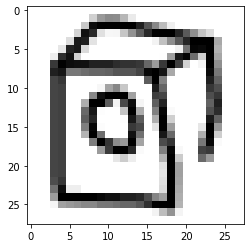

In [4]:
df = pd.read_csv('quickdraw_png_set1_train.csv', index_col=0)
df.head()

main_dir = 'quickdraw-png_set1/'

img = Image.open(os.path.join(main_dir, df.index[99]))
img = np.asarray(img, dtype=np.uint8)
print(img.shape)
plt.imshow(np.array(img), cmap='binary')
plt.show()

### Create a Custom Data Loader

In [5]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path, sep=",", index_col=0)
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df.index.values
        self.y = df['Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [6]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally


BATCH_SIZE = 128

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = QuickdrawDataset(txt_path='quickdraw_png_set1_train.csv',
                                 img_dir='quickdraw-png_set1/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4) 


valid_dataset = QuickdrawDataset(txt_path='quickdraw_png_set1_valid.csv',
                                img_dir='quickdraw-png_set1/',
                                transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4) 



test_dataset = QuickdrawDataset(txt_path='quickdraw_png_set1_train.csv',
                                img_dir='quickdraw-png_set1/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4) 

In [7]:
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [8]:
##########################
### MODEL
##########################


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Linear(120, 84),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [9]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [10]:
def print_sizes(self, input, output):

    print('Inside ' + self.__class__.__name__ + ' forward')
    print('input size:', input[0].size())
    print('output size:', output.data.size())

    
## Debugging

"""
model.features[0].register_forward_hook(print_sizes)
model.features[1].register_forward_hook(print_sizes)
model.features[2].register_forward_hook(print_sizes)
model.features[3].register_forward_hook(print_sizes)

model.classifier[0].register_forward_hook(print_sizes)
model.classifier[1].register_forward_hook(print_sizes)
model.classifier[2].register_forward_hook(print_sizes)
"""

'\nmodel.features[0].register_forward_hook(print_sizes)\nmodel.features[1].register_forward_hook(print_sizes)\nmodel.features[2].register_forward_hook(print_sizes)\nmodel.features[3].register_forward_hook(print_sizes)\n\nmodel.classifier[0].register_forward_hook(print_sizes)\nmodel.classifier[1].register_forward_hook(print_sizes)\nmodel.classifier[2].register_forward_hook(print_sizes)\n'

## Training

In [11]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))


    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Validation: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE),
              compute_accuracy(model, valid_loader, device=DEVICE) ))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/8290 | Cost: 2.3099
Epoch: 001/010 | Batch 0500/8290 | Cost: 0.7942
Epoch: 001/010 | Batch 1000/8290 | Cost: 0.5158
Epoch: 001/010 | Batch 1500/8290 | Cost: 0.4100
Epoch: 001/010 | Batch 2000/8290 | Cost: 0.5118
Epoch: 001/010 | Batch 2500/8290 | Cost: 0.3930
Epoch: 001/010 | Batch 3000/8290 | Cost: 0.4978
Epoch: 001/010 | Batch 3500/8290 | Cost: 0.4940
Epoch: 001/010 | Batch 4000/8290 | Cost: 0.4405
Epoch: 001/010 | Batch 4500/8290 | Cost: 0.4873
Epoch: 001/010 | Batch 5000/8290 | Cost: 0.5584
Epoch: 001/010 | Batch 5500/8290 | Cost: 0.5174
Epoch: 001/010 | Batch 6000/8290 | Cost: 0.6126
Epoch: 001/010 | Batch 6500/8290 | Cost: 0.4833
Epoch: 001/010 | Batch 7000/8290 | Cost: 0.5379
Epoch: 001/010 | Batch 7500/8290 | Cost: 0.4376
Epoch: 001/010 | Batch 8000/8290 | Cost: 0.5175
Epoch: 001/010 | Train: 87.360% | Validation: 87.256%
Time elapsed: 2.27 min
Epoch: 002/010 | Batch 0000/8290 | Cost: 0.5583
Epoch: 002/010 | Batch 0500/8290 | Cost: 0.3510
Epoch: 002/

## Evaluation

In [12]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 88.94%


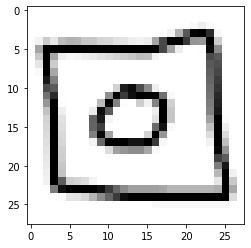

In [19]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
    
nhwc_img = np.transpose(features[5], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [22]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Washing Machine %.2f%%' % (probas[0][4]*100))

Probability Washing Machine 99.40%


In [23]:
%watermark -iv

torchvision 0.4.1a0+d94043a
matplotlib  3.1.0
numpy       1.17.2
pandas      0.24.2
PIL.Image   6.2.0
torch       1.3.0

